In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.utils import to_categorical

In [3]:
from numpy.random import seed
seed(123)  # 设置全局随机种子
from tensorflow import random
random.set_seed(123)  # 设置 TensorFlow 随机数种子

In [4]:
def rename (dataset_1,dataset_2,dataset_3):
    nn_1 = []
    lt_1 = list(dataset_1)
    for i in range(len(lt_1)):
        nn_1.append(lt_1[i]+'_1')
    dataset_1.columns = nn_1
    nn_2 = []
    lt_2 = list(dataset_2)
    for i in range(len(lt_2)):
        nn_2.append(lt_2[i]+'_2')
    dataset_2.columns = nn_2
    nn_3 = []
    lt_3 = list(dataset_3)
    for i in range(len(lt_3)):
        nn_3.append(lt_3[i]+'_3')
    dataset_3.columns = nn_3

In [5]:
def values (dataset):
    dataset['rl_wave'] = dataset['wave']
    dataset= dataset.drop(['wave'],axis=1)
    values = dataset.values #数值特征变量
    # convert series to supervised learning
    def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg
    # ensure all data is float
    values = values.astype('float32')
    # normalize features 歸一化
    ''''''
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    
    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)
    
    #reframed = series_to_supervised(values, 1, 1)
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[range(len(list(dataset)),len(list(dataset))*2)]], axis=1, inplace=True)
    
    # split into train and test sets
    values = reframed.values
    n_train_hours = int(len(values)*0.7)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:,:-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    return(train_X ,test_X,train_y,test_y)
    

In [6]:
#3成切割測試及驗證資料
def test_val(X,y):
    n_train_hours = int(len(X)/3)
    test_X = X[n_train_hours:, :]
    val_X = X[:n_train_hours, :]
    test_y = y[n_train_hours:]
    val_y = y[:n_train_hours]
    return(test_X,val_X,test_y,val_y)

In [7]:
sector = 'D'

In [8]:
def star_end(i):
    path = sector+':/openpose_data/揮手測試/'+i+'/標記.txt'
    f = open(path, 'r')
    #print(f.read())
    l = f.read().split()
    f.close()
    return(int(l[0][5:]),int(l[11][4:]))

In [9]:
tra_X = []
tes_X = []
tra_y = []
tes_y = []
val_X = []
val_y = []
number = 1

In [10]:
fn = ['揮手_右手向右','揮手_右手向左','揮手_左手向右','揮手_左手向左']
for i in fn:
    dataset_0 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/揮手測試_all_標記.csv')#, header= None) 
    dataset_1 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/揮手測試_相關距離.csv') 
    dataset_2 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/揮手測試_移動距離_1.csv') 
    dataset_3 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/揮手測試_關節角度.csv') 
    dataset_4 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/揮手測試_關節向量.csv') 
    rename(dataset_1,dataset_2,dataset_3)
    locals()['dataset_'+str(i)] = pd.concat([dataset_0,dataset_1,dataset_2,dataset_3,dataset_4],axis= 1).dropna(axis=0)
    star , end = star_end(i)
    print(star , end)
    locals()['dataset_'+str(i)] = locals()['dataset_'+str(i)][star:end]
    locals()['train_X_'+str(i)] ,locals()['test_X_'+str(i)] ,locals()['train_y_'+str(i)] ,locals()['test_y_'+str(i)] = values(locals()['dataset_'+str(i)])#.iloc[:,75:]

    locals()['train_y_'+str(i)][locals()['train_y_'+str(i)] ==1] = number
    locals()['test_y_'+str(i)][locals()['test_y_'+str(i)] ==1] = number
    #將其中3成分成1成驗證資料及3成測試資料
    locals()['test_X_'+str(i)] ,locals()['val_X_'+str(i)] ,locals()['test_y_'+str(i)] ,locals()['val_y_'+str(i)] = test_val(locals()['test_X_'+str(i)], locals()['test_y_'+str(i)])
    print(number)
    number = number+1

    tra_X.append(locals()['train_X_'+str(i)])
    tes_X.append(locals()['test_X_'+str(i)])
    tra_y.append(locals()['train_y_'+str(i)])
    tes_y.append(locals()['test_y_'+str(i)])
    val_X.append(locals()['val_X_'+str(i)])
    val_y.append(locals()['val_y_'+str(i)])
    
    print('訓練資料 : ',len(locals()['train_y_'+str(i)]))
    print('測試資料 : ',len(locals()['test_y_'+str(i)]))
    print('驗證資料 : ',len(locals()['val_y_'+str(i)]))

50 1035
1
訓練資料 :  688
測試資料 :  198
驗證資料 :  98
50 950
2
訓練資料 :  629
測試資料 :  180
驗證資料 :  90


C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexes\base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexes\base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


50 950
3
訓練資料 :  629
測試資料 :  180
驗證資料 :  90
40 1040
4
訓練資料 :  699
測試資料 :  200
驗證資料 :  100


C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexes\base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexes\base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [11]:
fn = ['畫圈_右手向右','畫圈_右手向左','畫圈_左手向右','畫圈_左手向左']
for i in fn:
    dataset_0 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/畫圈測試_all_標記.csv')#, header= None) 
    dataset_1 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/畫圈測試_相關距離.csv') 
    dataset_2 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/畫圈測試_移動距離_1.csv') 
    dataset_3 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/畫圈測試_關節角度.csv') 
    dataset_4 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/畫圈測試_關節向量.csv') 
    rename(dataset_1,dataset_2,dataset_3)
    locals()['dataset_'+str(i)] = pd.concat([dataset_0,dataset_1,dataset_2,dataset_3,dataset_4],axis= 1).dropna(axis=0)
    star , end = star_end(i)
    print(star , end)
    locals()['dataset_'+str(i)] = locals()['dataset_'+str(i)][star:end]
    locals()['train_X_'+str(i)] ,locals()['test_X_'+str(i)] ,locals()['train_y_'+str(i)] ,locals()['test_y_'+str(i)] = values(locals()['dataset_'+str(i)])#.iloc[:,75:]

    locals()['train_y_'+str(i)][locals()['train_y_'+str(i)] ==1] = number
    locals()['test_y_'+str(i)][locals()['test_y_'+str(i)] ==1] = number
    #將其中3成分成1成驗證資料及3成測試資料
    locals()['test_X_'+str(i)] ,locals()['val_X_'+str(i)] ,locals()['test_y_'+str(i)] ,locals()['val_y_'+str(i)] = test_val(locals()['test_X_'+str(i)], locals()['test_y_'+str(i)])
    print(number)
    number = number+1

    tra_X.append(locals()['train_X_'+str(i)])
    tes_X.append(locals()['test_X_'+str(i)])
    tra_y.append(locals()['train_y_'+str(i)])
    tes_y.append(locals()['test_y_'+str(i)])
    val_X.append(locals()['val_X_'+str(i)])
    val_y.append(locals()['val_y_'+str(i)])
    
    print('訓練資料 : ',len(locals()['train_y_'+str(i)]))
    print('測試資料 : ',len(locals()['test_y_'+str(i)]))
    print('驗證資料 : ',len(locals()['val_y_'+str(i)]))

40 760
5
訓練資料 :  503
測試資料 :  144
驗證資料 :  72
50 850
6
訓練資料 :  559
測試資料 :  160
驗證資料 :  80
30 1000
7
訓練資料 :  678
測試資料 :  194
驗證資料 :  97


C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexes\base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexes\base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.

30 850
8
訓練資料 :  573
測試資料 :  164
驗證資料 :  82


C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexes\base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [12]:
fn = ['踢腳_右腳向右','踢腳_左腳向左']#'踢腳_右腳向右','踢腳_左腳向左','起立蹲下'
for i in fn:
    dataset_0 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/骨架資訊_all_標記.csv')#, header= None) 
    dataset_1 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/骨架測試_相關距離.csv') 
    dataset_2 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/骨架測試_移動距離.csv') 
    dataset_3 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/骨架測試_關節角度(左右手).csv') 
    dataset_4 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/骨架測試_關節向量(左右手).csv') 
    rename(dataset_1,dataset_2,dataset_3)
    locals()['dataset_'+str(i)] = pd.concat([dataset_0,dataset_1,dataset_2,dataset_3,dataset_4],axis= 1).dropna(axis=0)
    star , end = star_end(i)
    print(star , end)
    locals()['dataset_'+str(i)] = locals()['dataset_'+str(i)][star:end]
    locals()['train_X_'+str(i)] ,locals()['test_X_'+str(i)] ,locals()['train_y_'+str(i)] ,locals()['test_y_'+str(i)] = values(locals()['dataset_'+str(i)])#.iloc[:,75:]

    locals()['train_y_'+str(i)][locals()['train_y_'+str(i)] ==1] = number
    locals()['test_y_'+str(i)][locals()['test_y_'+str(i)] ==1] = number
    #將其中3成分成1成驗證資料及3成測試資料
    locals()['test_X_'+str(i)] ,locals()['val_X_'+str(i)] ,locals()['test_y_'+str(i)] ,locals()['val_y_'+str(i)] = test_val(locals()['test_X_'+str(i)], locals()['test_y_'+str(i)])
    print(number)
    number = number+1

    tra_X.append(locals()['train_X_'+str(i)])
    tes_X.append(locals()['test_X_'+str(i)])
    tra_y.append(locals()['train_y_'+str(i)])
    tes_y.append(locals()['test_y_'+str(i)])
    val_X.append(locals()['val_X_'+str(i)])
    val_y.append(locals()['val_y_'+str(i)])
    
    print('訓練資料 : ',len(locals()['train_y_'+str(i)]))
    print('測試資料 : ',len(locals()['test_y_'+str(i)]))
    print('驗證資料 : ',len(locals()['val_y_'+str(i)]))

50 920
9
訓練資料 :  608
測試資料 :  174
驗證資料 :  87
70 960
10
訓練資料 :  622
測試資料 :  178
驗證資料 :  89


C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexes\base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexes\base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [13]:
train_X = tra_X[0]
test_X = tes_X[0]
train_y = tra_y[0]
test_y = tes_y[0]
vale_X = val_X[0]
vale_y = val_y[0]
for i in range(len(tra_X)-1):
    train_X = np.concatenate((train_X,tra_X[i+1]))
for i in range(len(tes_X)-1):
    test_X = np.concatenate((test_X,tes_X[i+1]))
for i in range(len(tra_y)-1):
    train_y = np.concatenate((train_y,tra_y[i+1]))
for i in range(len(tes_y)-1):
    test_y = np.concatenate((test_y,tes_y[i+1]))
    
for i in range(len(val_X)-1):
    vale_X = np.concatenate((vale_X,val_X[i+1]))
for i in range(len(val_y)-1):
    vale_y = np.concatenate((vale_y,val_y[i+1]))

In [14]:
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)
print(vale_X.shape)
print(vale_y.shape)

(6188, 1, 133)
(1772, 1, 133)
(6188,)
(1772,)
(885, 1, 133)
(885,)


In [15]:
# 準備資料集
X_train = train_X
y_train = train_y
X_test = test_X
y_test = test_y
X_vale = vale_X
y_vale = vale_y

In [16]:
# 建立 LSTM 模型
def create_model(neurons1=50, neurons2=50, neurons3=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(neurons1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(neurons2, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(neurons3))
    model.add(Dropout(dropout_rate))
    #model.add(Dense(1))
    
    #optimizer = Adam(learning_rate=learning_rate)
    #model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.add(Dense(11, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# # 定義要優化的超參數搜索範圍
# neurons1 = [50, 100, 150, 200]
# neurons2 = [50, 100, 150, 200]
# neurons3 = [50, 100, 150, 200]
# dropout_rates = [0.3] #[0.2, 0.3, 0.4]
# learning_rates = [0.001] # [0.001, 0.01]

# # 定義超參數搜索範圍
# param_grid = dict(neurons1=neurons1, neurons2=neurons2, neurons3=neurons3, dropout_rate=dropout_rates, learning_rate=learning_rates)

# # 建立超參數搜索方法
# model = KerasRegressor(build_fn=create_model, epochs=200, batch_size=64, verbose=0)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# # 將 y_train / y_test  轉換為 one-hot 編碼 因應softmax需求

# y_train_one_hot = to_categorical(y_train, num_classes=11)
# y_test_one_hot = to_categorical(y_test, num_classes=11)

# # 執行超參數搜索
# grid_result = grid.fit(X_train, y_train_one_hot)

# # 輸出最佳超參數
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# model = create_model(neurons1=grid_result.best_params_['neurons1'], neurons2=grid_result.best_params_['neurons2'], neurons3=grid_result.best_params_['neurons3'], dropout_rate=grid_result.best_params_['dropout_rate'], learning_rate=grid_result.best_params_['learning_rate'])
# history = model.fit(X_train, y_train_one_hot, epochs=200, batch_size=64, validation_data=(X_test, y_test_one_hot), verbose=0)


# # 使用最佳超參數訓練模型
# #model = create_model(neurons1=grid_result.best_params_['neurons1'], neurons2=grid_result.best_params_['neurons2'], neurons3=grid_result.best_params_['neurons3'], dropout_rate=grid_result.best_params_['dropout_rate'], learning_rate=grid_result.best_params_['learning_rate'])
# #history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=0)

# # 繪製學習曲線
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper right')
# plt.show()

# # 使用最佳模
# ''' '''

In [ ]:
grid_result = {'dropout_rate': 0.3,
 'learning_rate': 0.001,
 'neurons1': 150,
 'neurons2': 100,
 'neurons3': 50}

In [17]:
y_train_one_hot = to_categorical(y_train, num_classes=11)

In [18]:
y_train_one_hot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
# 將 y_train / y_test  轉換為 one-hot 編碼 因應softmax需求
y_train_one_hot = to_categorical(y_train, num_classes=11)
y_test_one_hot = to_categorical(y_test, num_classes=11)
y_vale_one_hot = to_categorical(y_vale, num_classes=11)

epochs = 50
model = create_model(neurons1=grid_result['neurons1'], neurons2=grid_result['neurons2'], neurons3=grid_result['neurons3'], dropout_rate=grid_result['dropout_rate'], learning_rate=grid_result['learning_rate'])
history = model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=64, validation_data=(X_vale, y_vale_one_hot), verbose=2 )

Epoch 1/50
97/97 - 5s - loss: 1.8320 - accuracy: 0.5370 - val_loss: 1.6611 - val_accuracy: 0.5367 - 5s/epoch - 46ms/step
Epoch 2/50
97/97 - 0s - loss: 1.3535 - accuracy: 0.5921 - val_loss: 1.1321 - val_accuracy: 0.6316 - 491ms/epoch - 5ms/step
Epoch 3/50
97/97 - 0s - loss: 0.8308 - accuracy: 0.7474 - val_loss: 0.6617 - val_accuracy: 0.7616 - 481ms/epoch - 5ms/step
Epoch 4/50
97/97 - 0s - loss: 0.4923 - accuracy: 0.8594 - val_loss: 0.3693 - val_accuracy: 0.8972 - 495ms/epoch - 5ms/step
Epoch 5/50
97/97 - 1s - loss: 0.3551 - accuracy: 0.8974 - val_loss: 0.3113 - val_accuracy: 0.9017 - 502ms/epoch - 5ms/step
Epoch 6/50
97/97 - 1s - loss: 0.3047 - accuracy: 0.9118 - val_loss: 0.3172 - val_accuracy: 0.9006 - 540ms/epoch - 6ms/step
Epoch 7/50
97/97 - 0s - loss: 0.2768 - accuracy: 0.9184 - val_loss: 0.3035 - val_accuracy: 0.8825 - 475ms/epoch - 5ms/step
Epoch 8/50
97/97 - 1s - loss: 0.2478 - accuracy: 0.9208 - val_loss: 0.2372 - val_accuracy: 0.9153 - 534ms/epoch - 6ms/step
Epoch 9/50
97/97 -

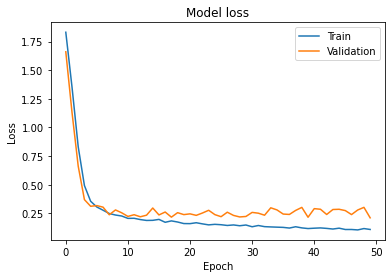

In [19]:
# 繪製學習曲線
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


### 儲存模型

In [20]:
# model.save('./model/lstm-Epoch'+str(epochs)+'.h5')

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 50
分類器的準確率為： 0.9356659142212189
分類器的錯誤筆數為： 114
Test RMSE: 1.595


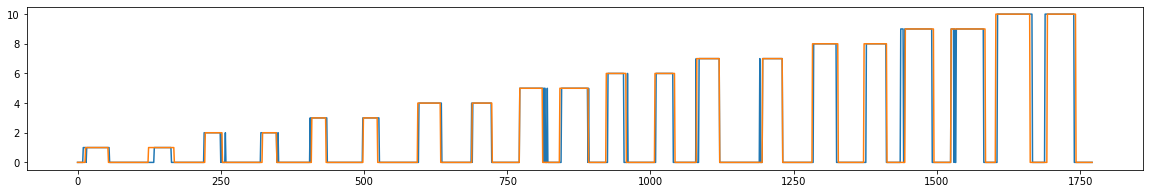

In [20]:
print(grid_result,'\n epochs:',epochs)
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test != predicted_labels)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

In [21]:
def fiveway(arr):
    # 将五个状态的元素分别设为 1、2、3、4、5
    arr_states = np.zeros((len(arr), 10), dtype=int)
    for i in range(1, 11):
        arr_states[:, i-1][arr == i] = 1
        
    # 使用卷积操作查找连续的五个相同的元素
    nb = 10
    kernel = np.ones(nb)
    result_states = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), axis=0, arr=arr_states)


    # 将大于等于 5 的元素视为当前状态，其他元素视为 0
    result_states[result_states < nb] = 0
    idx = np.where(result_states >= nb)

    # 使用布尔索引找到对应的行和列
    row_idx = idx[0]
    col_idx = idx[1]

    # 将值为 5 的位置改成对应的列号
    result_states[row_idx, col_idx] = col_idx + 1

    # 将所有状态的结果相加得到总结果
    result = np.sum(result_states, axis=1)

    # 输出结果
    return(result)

In [22]:
def show_conf_mat(cm):  #可視化混淆矩陣
    # 定义类别数量
    num_classes = cm.shape[0]

    # 生成类别标签
    #labels = ["Class {}".format(i+1) for i in range(num_classes)]
    labels = ['normal','wave RH to R','wave RH to L','wave LH to R','wave LH to L','circle RH to R','circle RH to L','circle LH to R','circle LH to L','kick R','kick L']
    
    #
    plt.figure(figsize=(10, 6))
    
    # 使用Seaborn來可視化混淆矩陣
    sns.set(font_scale=1.5)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

    # 添加標題和軸標籤
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # 顯示可視化結果
    plt.show()

In [23]:
def showreport(report):  #可視化混淆矩陣數值
    # 将report转换为DataFrame格式
    df = pd.DataFrame(report).transpose()

    # 为DataFrame添加列名
    df.columns = ['precision', 'recall', 'f1-score', 'support']
    
    df['CLASS'] = ['normal','wave RH to R','wave RH to L','wave LH to R','wave LH to L','circle RH to R','circle RH to L','circle LH to R','circle LH to L','kick R','kick L'
                 ,'accuracy','macro avg','weighted avg']
    df.set_index('CLASS', inplace=True) 
    ax = df.iloc[1:-3,:-1].plot.bar(rot=90)#rot表示xstick旋轉的角度
    ax.legend(bbox_to_anchor=(1.1, 1.2),ncol=3)
    print(df)
    
    # Export DataFrame to Excel
    df.to_excel('classification_report'+str(epochs)+'.xlsx', index=True)
    # 显示图形
    plt.show()

In [24]:
def show(y_true,y_pred):  #計算混淆矩陣及其相關評估數值
    # 计算混淆矩阵和分类报告
    conf_mat = confusion_matrix(y_true, y_pred)
    #report = classification_report(y_true, y_pred)
    report1 = classification_report(y_true, y_pred, output_dict=True)

    print(conf_mat)
    show_conf_mat(conf_mat)
    showreport(report1)

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 50
分類器的準確率為： 0.9424379232505643
分類器的錯誤筆數為： 102
Test RMSE: 1.562


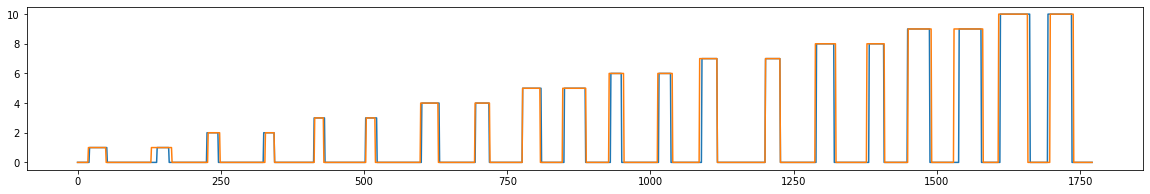

In [25]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)
predicted_labels_5 = fiveway(predicted_labels)
y_test_5 = fiveway(y_test)

rmse = math.sqrt(mean_squared_error(predicted_labels_5, y_test_5))

# 計算分類器的準確率
accuracy = accuracy_score(y_test_5, predicted_labels_5)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test_5 != predicted_labels_5)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels_5)
plt.plot(y_test_5)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()
#show(y_test_5,predicted_labels_5)

[[920   6   7   8   3   6   1   2   0   6   8]
 [ 16  69   0   0   0   0   0   0   0   0   0]
 [  2   0  53   0   0   0   0   0   0   0   0]
 [  0   0   0  50   0   0   0   0   0   0   0]
 [  4   0   0   0  71   0   0   0   0   0   0]
 [  4   0   0   0   0  86   0   0   0   0   0]
 [ 12   0   0   0   0   0  58   0   0   0   0]
 [  4   0   0   0   0   0   0  71   0   0   0]
 [ 10   0   0   0   0   0   0   0  75   0   0]
 [  9   0   0   0   0   0   0   0   0 101   0]
 [  6   0   0   0   0   0   0   0   0   0 104]]


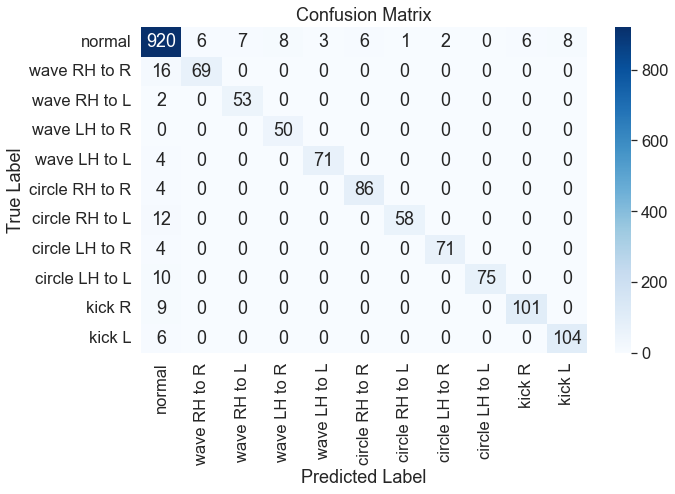

                precision    recall  f1-score      support
CLASS                                                     
normal           0.932118  0.951396  0.941658   967.000000
wave RH to R     0.920000  0.811765  0.862500    85.000000
wave RH to L     0.883333  0.963636  0.921739    55.000000
wave LH to R     0.862069  1.000000  0.925926    50.000000
wave LH to L     0.959459  0.946667  0.953020    75.000000
circle RH to R   0.934783  0.955556  0.945055    90.000000
circle RH to L   0.983051  0.828571  0.899225    70.000000
circle LH to R   0.972603  0.946667  0.959459    75.000000
circle LH to L   1.000000  0.882353  0.937500    85.000000
kick R           0.943925  0.918182  0.930876   110.000000
kick L           0.928571  0.945455  0.936937   110.000000
accuracy         0.935666  0.935666  0.935666     0.935666
macro avg        0.938174  0.922750  0.928536  1772.000000
weighted avg     0.936833  0.935666  0.935368  1772.000000


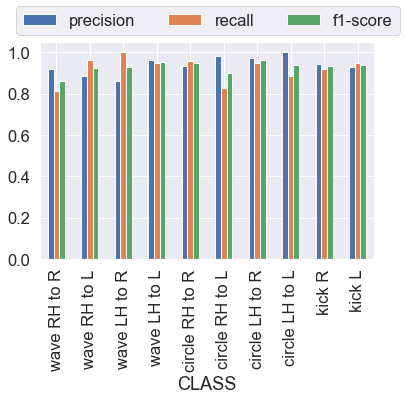

In [26]:
show(y_test, predicted_labels)

In [27]:
from tensorflow.keras.models import load_model
epochs_test = 50
testmodel = load_model('./model/lstm-Epoch'+str(epochs_test)+'.h5')

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 50
分類器的準確率為： 0.9356659142212189
分類器的錯誤筆數為： 114
Test RMSE: 1.595


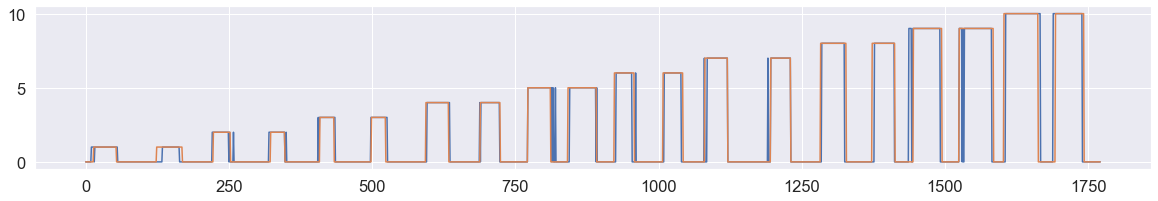

In [28]:
print(grid_result,'\n epochs:',epochs_test)
yhat = testmodel.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test != predicted_labels)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 50
分類器的準確率為： 0.9424379232505643
分類器的錯誤筆數為： 102
Test RMSE: 1.562


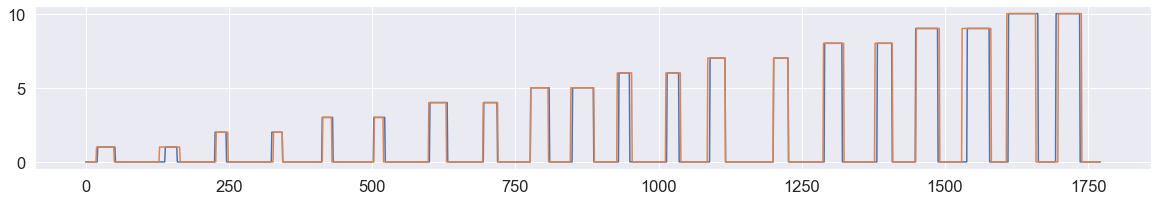

In [29]:
print(grid_result,'\n epochs:',epochs_test)# softmax
yhat = testmodel.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)
predicted_labels_5 = fiveway(predicted_labels)
y_test_5 = fiveway(y_test)

rmse = math.sqrt(mean_squared_error(predicted_labels_5, y_test_5))

# 計算分類器的準確率
accuracy = accuracy_score(y_test_5, predicted_labels_5)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test_5 != predicted_labels_5)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels_5)
plt.plot(y_test_5)
plt.show()


[[920   6   7   8   3   6   1   2   0   6   8]
 [ 16  69   0   0   0   0   0   0   0   0   0]
 [  2   0  53   0   0   0   0   0   0   0   0]
 [  0   0   0  50   0   0   0   0   0   0   0]
 [  4   0   0   0  71   0   0   0   0   0   0]
 [  4   0   0   0   0  86   0   0   0   0   0]
 [ 12   0   0   0   0   0  58   0   0   0   0]
 [  4   0   0   0   0   0   0  71   0   0   0]
 [ 10   0   0   0   0   0   0   0  75   0   0]
 [  9   0   0   0   0   0   0   0   0 101   0]
 [  6   0   0   0   0   0   0   0   0   0 104]]


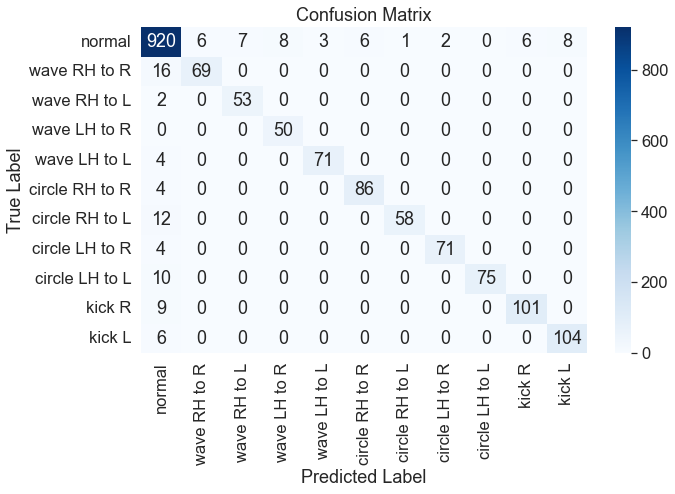

                precision    recall  f1-score      support
CLASS                                                     
normal           0.932118  0.951396  0.941658   967.000000
wave RH to R     0.920000  0.811765  0.862500    85.000000
wave RH to L     0.883333  0.963636  0.921739    55.000000
wave LH to R     0.862069  1.000000  0.925926    50.000000
wave LH to L     0.959459  0.946667  0.953020    75.000000
circle RH to R   0.934783  0.955556  0.945055    90.000000
circle RH to L   0.983051  0.828571  0.899225    70.000000
circle LH to R   0.972603  0.946667  0.959459    75.000000
circle LH to L   1.000000  0.882353  0.937500    85.000000
kick R           0.943925  0.918182  0.930876   110.000000
kick L           0.928571  0.945455  0.936937   110.000000
accuracy         0.935666  0.935666  0.935666     0.935666
macro avg        0.938174  0.922750  0.928536  1772.000000
weighted avg     0.936833  0.935666  0.935368  1772.000000


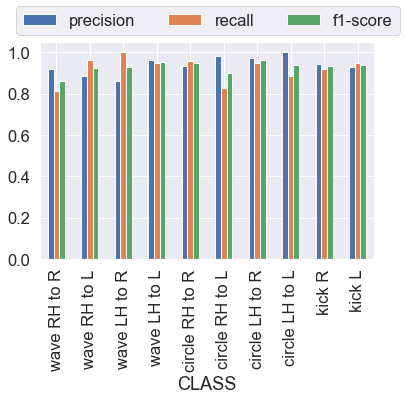

In [30]:
show(y_test, predicted_labels)